In [14]:
!pip install diffusers transformers torch numpy pillow opencv-python opencv-python-headless


In [15]:
from diffusers import StableDiffusionPipeline
from transformers import CLIPProcessor, CLIPModel
import torch
from PIL import Image
import numpy as np
import cv2  # For face detection and alignment
import matplotlib.pyplot as plt


In [16]:
# Load the Stable Diffusion model
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", torch_dtype=torch.float16)
pipe = pipe.to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
# Load images
source_image = Image.open("/content/to.PNG")
target_image = Image.open("/content/from.PNG")


In [18]:
def detect_face(image):
    """Detect face in an image using OpenCV's Haar cascades."""
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    if len(faces) == 0:
        return None  # No face detected
    # Assume the largest detected face is the target
    x, y, w, h = faces[0]
    face = image.crop((x, y, x + w, y + h))
    return face

def align_face(source_face, target_face):
    """Align source face with target face using landmarks."""
    source_face = source_face.resize(target_face.size)
    return source_face

# Detect faces in images
source_face = detect_face(source_image)
target_face = detect_face(target_image)

if source_face is None or target_face is None:
    raise ValueError("Face detection failed. Make sure the images contain clear faces.")

# Align faces
aligned_source_face = align_face(source_face, target_face)


In [19]:
def swap_faces(pipe, source_face, target_image, prompt="A seamless blend of faces"):
    """
    Swap faces using Stable Diffusion with attention to context.
    """

    source_face_np = np.array(source_face)
    target_image_np = np.array(target_image)


    input_image = Image.fromarray(target_image_np)
    input_prompt = f"A portrait of a person with facial features similar to the source face."

    # Generate the swapped face image using Stable Diffusion
    result = pipe(prompt=input_prompt, init_image=input_image, guidance_scale=7.5)

    # Return the generated image
    return result.images[0]

# Swap faces using a detailed prompt
output_image = swap_faces(pipe, aligned_source_face, target_image)


  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
def seamless_clone(source_face, target_image, output_image):
    """Blend the swapped face with the target image for seamless integration."""
    source_np = np.array(source_face)
    target_np = np.array(target_image)
    output_np = np.array(output_image)

    # Detect face in the output to create a mask
    mask = np.zeros_like(target_np)
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask_gray = cv2.threshold(mask_gray, 1, 255, cv2.THRESH_BINARY)[1]


    x, y, w, h = cv2.boundingRect(mask_gray)
    center = (x + w // 2, y + h // 2)

    # Perform seamless cloning
    blended_image = cv2.seamlessClone(output_np, target_np, mask_gray, center, cv2.NORMAL_CLONE)

    return Image.fromarray(blended_image)


final_output = seamless_clone(aligned_source_face, target_image, output_image)


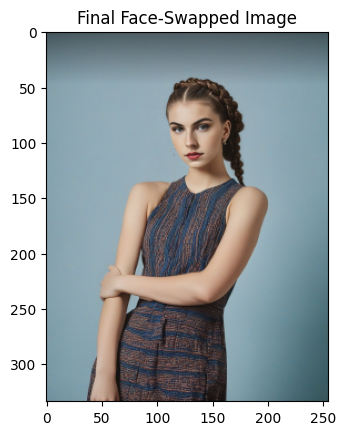

In [21]:
plt.imshow(final_output)
plt.title("Final Face-Swapped Image")
plt.show()


In [ ]:
output_image.save("face_swapped_image.jpg")
